### Final Project

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
#from plotly.offline import plotpip install 
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
#import statsmodels.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split,KFold,cross_val_score
import re
import json
from pandas.io.json import json_normalize

In [3]:
# crimedata = pd.read_csv("crimedata.csv",sep='\s*,\s*',encoding='latin-1',engine='python',na_values=["?"]) # Read the csv file into dataframe
# crimedata = crimedata.rename(columns={'Êcommunityname':'communityName'})
# print (crimedata.info())

# # fill missing values for the select columns under study with median value of the select columns
# cols = ['HousVacant','PctHousOccup','PctHousOwnOcc','PctVacantBoarded','PctVacMore6Mos','PctUnemployed','PctEmploy','murdPerPop','rapesPerPop','robbbPerPop','assaultPerPop','ViolentCrimesPerPop','burglPerPop','larcPerPop','autoTheftPerPop','arsonsPerPop','nonViolPerPop']
# crimedata.fillna(crimedata[cols].median(),inplace=True)

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt

import plotly.graph_objs as go
#from plotly.offline import plot
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
#import statsmodels.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split,KFold,cross_val_score
import re
import json
from pandas.io.json import json_normalize

In [5]:

crimedata = pd.read_csv("crimedata.csv",sep='\s*,\s*',encoding='latin-1',engine='python',na_values=["?"]) # Read the csv file into dataframe
crimedata = crimedata.rename(columns={'Êcommunityname':'communityName'})
print (crimedata.info())

# fill missing values for the select columns under study with median value of the select columns
cols = ['HousVacant','PctHousOccup','PctHousOwnOcc','PctVacantBoarded','PctVacMore6Mos','PctUnemployed','PctEmploy','murdPerPop','rapesPerPop','robbbPerPop','assaultPerPop','ViolentCrimesPerPop','burglPerPop','larcPerPop','autoTheftPerPop','arsonsPerPop','nonViolPerPop']
crimedata.fillna(crimedata[cols].median(),inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Columns: 147 entries, communityName to nonViolPerPop
dtypes: float64(116), int64(29), object(2)
memory usage: 2.5+ MB
None


In [6]:
crimedata_state = crimedata.groupby('state').agg({'ViolentCrimesPerPop':'mean','nonViolPerPop':'mean'})[['ViolentCrimesPerPop','nonViolPerPop']].reset_index()

##Aggregate view of Non-Violent Crimes by State
data1 = dict(type='choropleth',
        colorscale = 'Viridis',
        autocolorscale = False,
        locations = crimedata_state['state'],
        locationmode = 'USA-states',
        z = crimedata_state['nonViolPerPop'].astype(float),
        colorbar = {'title':'non-Violent Crimes(Per-100K-Pop)'}
        )
layout1 = dict(
        title = 'Aggregate view of non-Violent Crimes Per 100K Population',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor='rgb(85,173,240)'),
             )
    
fig1 = go.Figure(data = [data1],layout = layout1)
iplot(fig1,validate=False)

##Aggregate view of Violent Crimes by State
data2 = dict(type='choropleth',
        autocolorscale = False,
        colorscale = "Jet",
        locations = crimedata_state['state'],
        locationmode = 'USA-states',
        z = crimedata_state['ViolentCrimesPerPop'].astype('float'),
        colorbar = {'title':'Violent Crimes(Per-100K-Pop)'}
        )
layout2 = dict(
        title = 'Aggregate view of Violent Crimes Per 100K Population across US',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(85,173,240)'),
             )
    
fig2 = go.Figure(data = [data2],layout = layout2)
iplot(fig2,validate=False)


In [7]:
## Check if there is multicollinearity between any of the explanatory variables under study
cols = ['HousVacant','PctHousOccup','PctHousOwnOcc','PctVacantBoarded','PctVacMore6Mos','PctUnemployed','PctEmploy','murdPerPop','rapesPerPop','robbbPerPop','assaultPerPop','ViolentCrimesPerPop','burglPerPop','larcPerPop','autoTheftPerPop','arsonsPerPop','nonViolPerPop']
crimedata_study = crimedata.filter(cols, axis=1)
corr_crimedata_study = crimedata_study.corr()
iv_corr = corr_crimedata_study.iloc[:-10,:-10]
multicol_limit = 0.3
iv_corr = (iv_corr[abs(iv_corr) > multicol_limit][iv_corr != 1.0]).unstack().to_dict()
iv_multicoll_corr = pd.DataFrame(list(set([(tuple(sorted(key)), iv_corr[key]) for key in iv_corr])), 
        columns=['Independent Variables', 'Correlation Coefficient'])
print (iv_multicoll_corr[iv_multicoll_corr.notnull().all(axis=1)])

                 Independent Variables  Correlation Coefficient
8          (PctEmploy, PctVacMore6Mos)                -0.372459
13      (PctHousOwnOcc, PctUnemployed)                -0.394427
23   (PctUnemployed, PctVacantBoarded)                 0.549636
28          (PctEmploy, PctUnemployed)                -0.676430
32  (PctVacMore6Mos, PctVacantBoarded)                 0.366664
37       (PctEmploy, PctVacantBoarded)                -0.342344
40           (PctEmploy, PctHousOccup)                 0.341939


In [8]:
# Let's find out the outliers in `ViolentCrimesPerPop` response variable and plot those to find cities with highest crime rate in the US
quartile_1, quartile_3 = np.percentile(crimedata['ViolentCrimesPerPop'], [25, 75])
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
outliers_viol = crimedata.loc[crimedata['ViolentCrimesPerPop']>upper_bound,['communityName','state','ViolentCrimesPerPop']]


## Let's find out the outliers in `nonViolPerPop` response variable and plot those to find cities with highest crime rate in the US
quartile_1, quartile_3 = np.percentile(crimedata['nonViolPerPop'], [25, 75])
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
outliers_nviol = crimedata.loc[crimedata['nonViolPerPop']>upper_bound,['communityName','state','nonViolPerPop']]

## Remove community Name(s) ending with "city". This helps dataframe(s) merging easier to get lat and lon
outliers_viol['communityName'] = outliers_viol['communityName'].map(lambda result : re.sub(r'city','',result))
outliers_nviol['communityName'] = outliers_nviol['communityName'].map(lambda result : re.sub(r'city','',result))

## read citie.json file to get latitude and longitude details of the cities
file = "cities.json"
with open(file, encoding="utf8") as city_file:
   dict_city = json.load(city_file)
cities_lat_lon = json_normalize(dict_city)
print(cities_lat_lon)
#print (cities_lat_lon.info())

## merge cities dataframe(with cities_lat_lon dataframe to get lat and lon of the cities) with outliers_viol dataframe 
##and outliers_nviol to plot cities with highest violent/non-vilolent crime rate

violent_crime_cities = pd.merge(outliers_viol,cities_lat_lon,left_on=["communityName","state"],right_on=["city","state"])
violent_crime_cities = violent_crime_cities.drop(["city"],axis=1)
#print (violent_crime_cities)

nonviolent_crime_cities = pd.merge(outliers_nviol,cities_lat_lon,left_on=["communityName","state"],right_on=["city","state"])
nonviolent_crime_cities = nonviolent_crime_cities.drop(["city"],axis=1)
#print (nonviolent_crime_cities)


## Cities with highest  non-violent crime rate
levels = [(0,20),(21,30),(31,40),(41,50),(51,80)]
colors = ['rgb(255,133,27)','rgb(31,120,180)','rgb(178,223,138)','rgb(251,154,153)','rgb(227,26,28)']
plot_data = []
for i in range(len(levels)):
    lim = levels[i]
    nonviolent_crime_cities_sub = nonviolent_crime_cities[lim[0]:lim[1]]
    city_outline = dict(
        type = "scattergeo",
        locationmode = 'USA-states',
        lon = nonviolent_crime_cities_sub['longitude'],
        lat = nonviolent_crime_cities_sub['latitude'],
        text = nonviolent_crime_cities_sub['communityName'] +' '+ nonviolent_crime_cities_sub['nonViolPerPop'].astype(str),
        mode = "markers",
        marker = dict(
        size = nonviolent_crime_cities_sub['nonViolPerPop']/800,
        color = colors[i],
        ),  
    name = '{0} - {1}'.format(lim[0],lim[1])
    )
    layout1 = dict(
        title = 'Cities with highest non-Violent Crime rate',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(85,173,240)'), 
    )
    plot_data.append(city_outline)
    
fig1= dict( data=plot_data, layout=layout1)
iplot( fig1, validate=False)
    
    
## Cities with highest violent crime rate
levels = [(0,30),(31,60),(61,90),(91,120),(121,170)]
colors = ['rgb(175,175,50)','rgb(131,120,180)','rgb(78,230,138)','rgb(251,24,153)','rgb(227,126,28)']
cities = []
for i in range(len(levels)):
    lim = levels[i]
    violent_crime_cities_sub = violent_crime_cities[lim[0]:lim[1]]
    city_outline = dict(
        type = "scattergeo",
        locationmode = 'USA-states',
        lon = violent_crime_cities_sub['longitude'],
        lat = violent_crime_cities_sub['latitude'],
        text = violent_crime_cities_sub['communityName'] +' '+ violent_crime_cities_sub['ViolentCrimesPerPop'].astype(str),
        mode = "markers",
        marker = dict(
        size = violent_crime_cities_sub['ViolentCrimesPerPop']/200,
        color = colors[i]
        ),  
    name = '{0} - {1}'.format(lim[0],lim[1])
    )
    layout2 = dict(
        title = 'Cities with highest Violent Crime rate',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(85,173,240)'),
    ) 
    cities.append(city_outline)
    
fig2= dict( data=cities, layout=layout2)
iplot( fig2, validate=False)

               city   latitude   longitude state
0           NewYork  40.712784  -74.005941    NY
1        Greenville  35.612700  -77.366400    NC
2              Waco  31.549300  -97.146700    TX
3          Richmond  37.935800 -122.347700    CA
4        LosAngeles  34.052234 -118.243685    CA
..              ...        ...         ...   ...
237       Hamtramck  42.392800  -83.049600    MI
238          Eureka  40.802100 -124.163700    CA
239    BentonHarbor  42.116700  -86.454200    MI
240       Montclair  34.077510 -117.689778    CA
241  Greenfieldtown  42.587900  -72.599400    MA

[242 rows x 4 columns]


<ipython-input-8-3d81cab2ef98>:24: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



## Creating Boxplots to see the general distribution of violent and non-violent. 

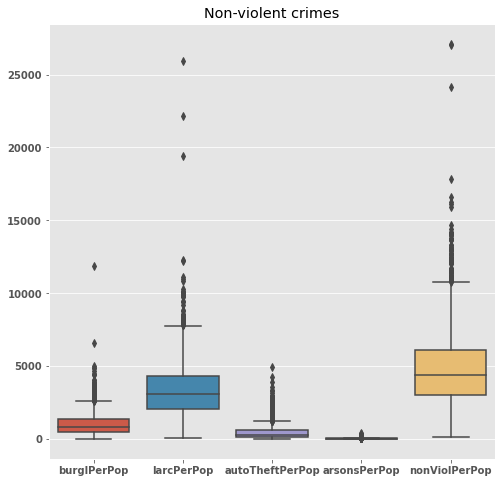

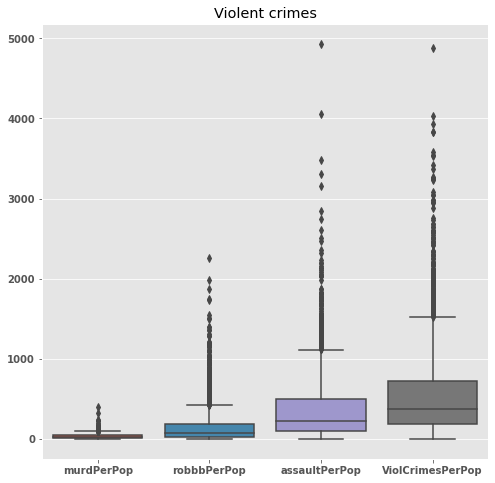

In [50]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

plt.rc('font', **font)


#Boxplot of non violent crime variables
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
nonViolent = crimedata_study[cols[12:17]]
xticklablesNV = ['burglPerPop','larcPerPop','autoTheftPerPop','arsonsPerPop','nonViolPerPop']
sns.boxplot(data=nonViolent)
ax.set(title="Non-violent crimes")
ax.set_xticklabels(xticklablesNV)
plt.show()


#Boxplot of Violent crime variables
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
Violent = crimedata_study[cols[8:12]]
xticklablesV = ['murdPerPop','robbbPerPop','assaultPerPop','ViolCrimesPerPop']
sns.boxplot(data=Violent)
ax.set(title="Violent crimes")
ax.set_xticklabels(xticklablesV)
plt.show()

## Creating a correlation matrix using violent crime, non-violent crime, and basic housing data

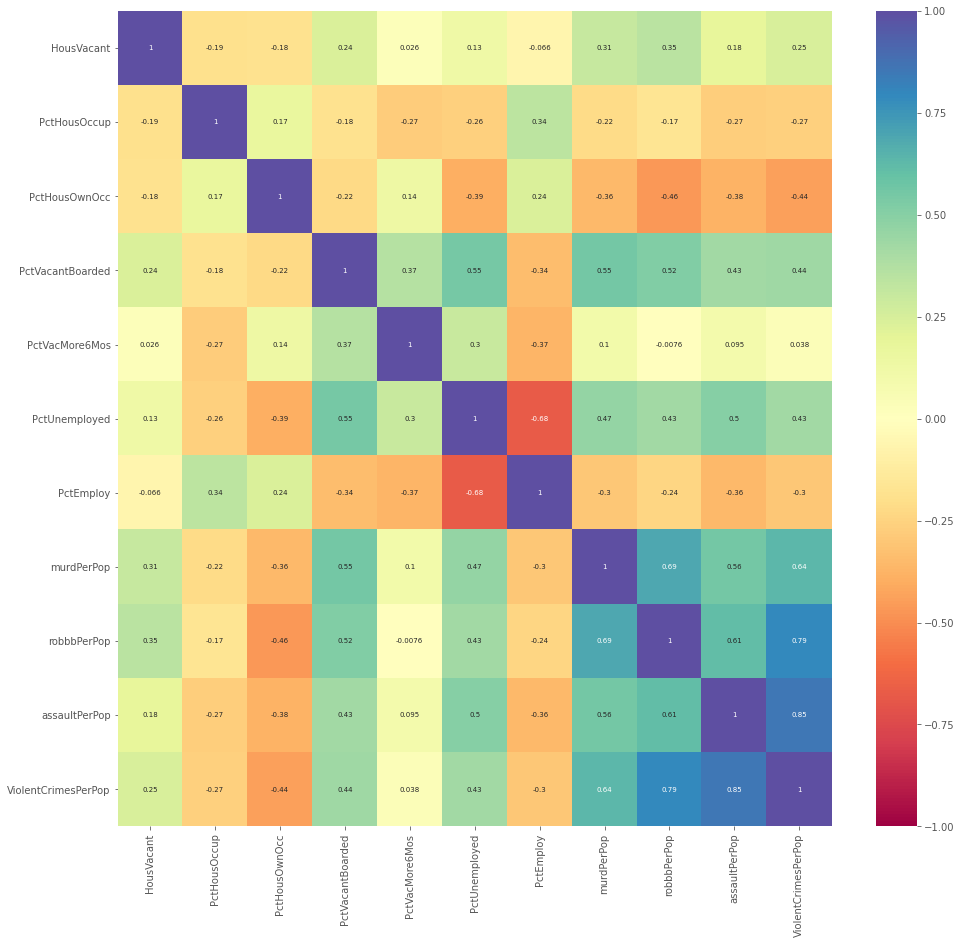

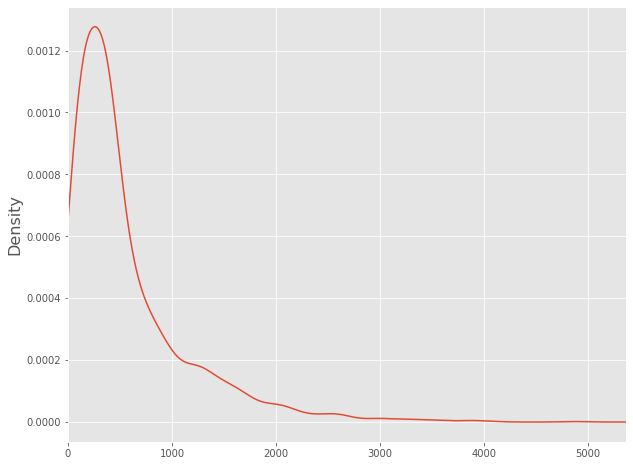

In [359]:
cols = ['HousVacant','PctHousOccup','PctHousOwnOcc','PctVacantBoarded','PctVacMore6Mos','PctUnemployed','PctEmploy','murdPerPop','robbbPerPop','assaultPerPop','ViolentCrimesPerPop','burglPerPop','larcPerPop','autoTheftPerPop','arsonsPerPop','nonViolPerPop']
crimedata_study = crimedata.filter(cols, axis=1)

### Find out the correlation between explanatory and response under study variables. Indepentdent variables under study is limited
### to Income and employment considering the huge number of variables in the dataset
crimedata_reg = crimedata_study.drop(['burglPerPop','larcPerPop','autoTheftPerPop','arsonsPerPop','nonViolPerPop'],axis=1)
crimedata_reg_corr = crimedata_reg.corr()

### correlation matrix plot
plt.figure(figsize=(16,15))
sns.heatmap(crimedata_reg_corr,annot=True,annot_kws={"size": 7},vmin=-1.0, vmax=1.0,cmap="Spectral")

## "ViolentCrimesPerPop" Density plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax= crimedata_reg['ViolentCrimesPerPop'].plot(kind="kde")
plt.xlim(crimedata_reg['ViolentCrimesPerPop'].min(), crimedata_reg['ViolentCrimesPerPop'].max()*1.1)
plt.show()


In [360]:
## We can see that the density plot is right skewed and further from the boxplot for the response variable "ViolentCrimesPerPop"
## shows the spread of  many outlier data points above the third quartile


## Multiple Linear Regression of variables under study
X = crimedata_reg[['HousVacant','PctHousOccup','PctHousOwnOcc','PctVacantBoarded','PctVacMore6Mos','PctUnemployed','PctEmploy']]
y = crimedata_reg['ViolentCrimesPerPop']
## using statsmodel 
##X = sm.add_constant(X)
##mregmodel = sm.OLS(y,X).fit()
##print (mregmodel.summary())
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1)
# fit a model
lm = linear_model.LinearRegression()
mmodel = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
coefficients = mmodel.coef_
print("The coeffcients of our model is {}".format(coefficients))
intercept = mmodel.intercept_
print("The intercept for our model is {}".format(intercept))
print ("Linear model Train dataset score is {}".format(mmodel.score(X_train,y_train)))
print ("Linear model Test dataset score is {}".format(mmodel.score(X_test,y_test)))

##Linear regression using KFold Cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=0)
results = next(kf.split(X), None)
X_train,y_train = X.iloc[results[0]], y.iloc[results[0]]
X_test,y_test = X.iloc[results[1]],y.iloc[results[1]]

lm = linear_model.LinearRegression()
mm_scores = cross_val_score(lm,X,y,cv=kf)
print ("Cross Validatation Score is {}".format(mm_scores))
print ("Cross Validatation Score mean is {}".format(mm_scores.mean()))
print ("Cross Validatation standard deviation is {}".format(mm_scores.std()))

The coeffcients of our model is [ 7.54745466e-03 -1.41786715e+01 -1.10271206e+01  4.95497305e+01
 -5.33677041e+00  1.98332262e+01 -4.35120857e+00]
The intercept for our model is 2768.815670578978
Linear model Train dataset score is 0.35931157284880066
Linear model Test dataset score is 0.37412307383981225
Cross Validatation Score is [0.36829157 0.2681317  0.26355751 0.45933171 0.31706041 0.47669981
 0.34282423 0.32520228 0.47142926 0.28387437]
Cross Validatation Score mean is 0.3576402835870115
Cross Validatation standard deviation is 0.07924703838521945


### Create a Machine Learning Model 

In [8]:
# TURN ON the GPU !

import os
from operator import itemgetter    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder, LabelBinarizer
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, cross_val_predict, StratifiedKFold, train_test_split, learning_curve, ShuffleSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor, VotingRegressor, AdaBoostRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

import tensorflow as tf

from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

print(os.getcwd())
print("Modules imported \n")

C:\Users\Frank\Documents\1.0 Vanderbilt\PHYS-8100-Machine-Learning\Final Project
Modules imported 



In [21]:
##Reading the Crime and changing the column names. 
crimedata = pd.read_csv("crimedata.csv",sep='\s*,\s*',encoding='latin-1',engine='python',na_values=["?"]) # Read the csv file into dataframe
crimedata = crimedata.rename(columns={'Êcommunityname':'communityName'})
print (crimedata.info())

# fill missing values/ "NAN/?" for the select columns under study with median value of the select columns
# 
cols = ['HousVacant','PctHousOccup','PctHousOwnOcc','PctVacantBoarded','PctVacMore6Mos', 
        'PctUnemployed','PctEmploy','murdPerPop','rapesPerPop','robbbPerPop','assaultPerPop', 
        'ViolentCrimesPerPop','burglPerPop','larcPerPop','autoTheftPerPop','arsonsPerPop','nonViolPerPop',
        'LemasSwornFT',  'LemasSwFTPerPop',  'LemasSwFTFieldOps',  'LemasSwFTFieldPerPop',  'LemasTotalReq', 
        'LemasTotReqPerPop',  'PolicReqPerOffic',  'PolicPerPop',  'RacialMatchCommPol',  'PctPolicWhite',  
        'PctPolicBlack',  'PctPolicHisp',  'PctPolicAsian',  'PctPolicMinor',  'OfficAssgnDrugUnits',  
        'NumKindsDrugsSeiz',  'PolicAveOTWorked',  'LandArea',  'PopDens',  'PctUsePubTrans',  'PolicCars',  
        'PolicOperBudg',  'LemasPctPolicOnPatr',  'LemasGangUnitDeploy',  'LemasPctOfficDrugUn',  'PolicBudgPerPop', 
        'murders'
       ]
crimedata.fillna(crimedata[cols].median(),inplace=True)


data_full = crimedata
print("With id", data_full.shape)
#X = data_full.drop(['ViolentCrimesPerPop','communityName','state','rapesPerPop', 
#                   'murdPerPop','rapesPerPop','robbbPerPop','assaultPerPop', 'rapes', 'assaults']  ,1)
X = data_full.drop(['ViolentCrimesPerPop','rapesPerPop', 'communityName',
                   'murdPerPop','rapesPerPop','robbbPerPop','assaultPerPop', 'rapes', 'assaults']  ,1)

y = data_full['ViolentCrimesPerPop']

print("y - Labels", y.shape)
print("X - No Label No id No expired", X.shape)
print(X.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Columns: 147 entries, communityName to nonViolPerPop
dtypes: float64(116), int64(29), object(2)
memory usage: 2.5+ MB
None
With id (2215, 147)
y - Labels (2215,)
X - No Label No id No expired (2215, 139)
Index(['state', 'countyCode', 'communityCode', 'fold', 'population',
       'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian',
       'racePctHisp',
       ...
       'robberies', 'burglaries', 'burglPerPop', 'larcenies', 'larcPerPop',
       'autoTheft', 'autoTheftPerPop', 'arsons', 'arsonsPerPop',
       'nonViolPerPop'],
      dtype='object', length=139)


In [22]:
print(data_full.shape)
data_full.info()
data_full.describe()

(2215, 147)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Columns: 147 entries, communityName to nonViolPerPop
dtypes: float64(116), int64(29), object(2)
memory usage: 2.5+ MB


,countyCode,communityCode,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
count,994.000000,991.000000,2215.000000,2.215000e+03,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,...,2212.000000,2215.000000,2212.000000,2215.000000,2212.000000,2215.000000,2124.000000,2215.000000,2215.000000,2215.000000
mean,65.587525,45209.251261,5.494357,5.311798e+04,2.707327,9.335102,83.979819,2.670203,7.950176,14.445837,...,761.236890,1033.144810,2137.629295,3372.581675,516.692586,473.733199,30.907721,31.698736,567.625567,4887.099228
std,117.831399,25425.861573,2.872924,2.046203e+05,0.334120,14.247156,16.419080,4.473843,14.589832,4.518623,...,3111.702756,762.876468,7600.573464,1900.058222,3258.164244,504.363503,180.125248,38.488835,586.844780,2680.842377
min,1.000000,70.000000,1.000000,1.000500e+04,1.600000,0.000000,2.680000,0.030000,0.120000,4.580000,...,2.000000,16.920000,10.000000,77.860000,1.000000,6.550000,0.000000,0.000000,0.000000,116.790000
25%,11.000000,22887.000000,3.000000,1.436600e+04,2.500000,0.860000,76.320000,0.620000,0.930000,12.250000,...,95.000000,512.185000,392.000000,2040.740000,30.000000,157.060000,1.000000,7.985000,185.280000,2994.265000
50%,27.000000,46925.000000,5.000000,2.279200e+04,2.660000,2.870000,90.350000,1.230000,2.180000,13.620000,...,205.000000,822.715000,747.000000,3079.510000,75.000000,302.355000,5.000000,21.080000,374.060000,4425.450000
75%,80.500000,65805.000000,8.000000,4.302400e+04,2.850000,11.145000,96.225000,2.670000,7.810000,15.360000,...,508.000000,1348.670000,1675.000000,4334.675000,232.500000,589.225000,16.000000,41.435000,722.000000,6100.870000
max,840.000000,94597.000000,10.000000,7.322564e+06,5.280000,96.670000,99.630000,57.460000,95.290000,54.400000,...,99207.000000,11881.020000,235132.000000,25910.550000,112464.000000,4968.590000,5119.000000,436.370000,4877.060000,27119.760000


In [23]:
data_full.head(10)

,communityName,state,countyCode,communityCode,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39.0,5320.0,1,11980,3.10,1.37,91.78,6.50,...,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,Marpletownship,PA,45.0,47616.0,1,23123,2.82,0.80,95.57,3.44,...,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,Tigardcity,OR,NaN,NaN,1,29344,2.43,0.74,94.33,3.43,...,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51
3,Gloversvillecity,NY,35.0,29443.0,1,16656,2.40,1.70,97.35,0.50,...,225.0,1301.78,716.0,4142.56,47.0,271.93,NaN,21.08,306.64,4425.45
4,Bemidjicity,MN,7.0,5068.0,1,11245,2.76,0.53,89.16,1.17,...,91.0,728.93,1060.0,8490.87,91.0,728.93,5.0,40.05,374.06,9988.79
5,Springfieldcity,MO,NaN,NaN,1,140494,2.45,2.51,95.65,0.90,...,2094.0,1386.46,7690.0,5091.64,454.0,300.60,134.0,88.72,442.95,6867.42
6,Norwoodtown,MA,21.0,50250.0,1,28700,2.60,1.60,96.57,1.47,...,110.0,372.09,288.0,974.19,144.0,487.10,17.0,57.50,226.63,1890.88
7,Andersoncity,IN,NaN,NaN,1,59459,2.45,14.20,84.87,0.40,...,608.0,997.60,2250.0,3691.79,125.0,205.10,9.0,14.77,439.73,4909.26
8,Fargocity,ND,17.0,25700.0,1,74111,2.46,0.35,97.11,1.25,...,425.0,532.66,3149.0,3946.71,206.0,258.18,8.0,10.03,115.31,4747.58
9,Wacocity,TX,NaN,NaN,1,103590,2.62,23.14,67.60,0.92,...,2397.0,2221.81,6121.0,5673.63,1070.0,991.80,18.0,16.68,1544.24,8903.93


In [24]:
##Attempting to show a histogram of Data

data_full.hist( figsize=(40,60))
plt.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


KeyboardInterrupt: 

In [25]:
# from pandas.plotting import scatter_matrix

# scatter_matrix(data_full.loc[:, data_full.columns] ,  figsize  = [30, 30], diagonal = "kde")
# plt.show()

In [26]:
# Pearson linear correlation

corr_matrix = data_full.corr()
corr_matrix["ViolentCrimesPerPop"].sort_values(ascending=False)

ViolentCrimesPerPop    1.000000
assaultPerPop          0.852080
robbbPerPop            0.789590
PctKidsBornNeverMar    0.686665
burglPerPop            0.676466
                         ...   
PctYoungKids2Par      -0.611884
PctTeen2Par           -0.616963
racePctWhite          -0.647164
PctFam2Par            -0.649762
PctKids2Par           -0.684059
Name: ViolentCrimesPerPop, Length: 145, dtype: float64

In [27]:
# Check that all X columns have no missing values
X.info()
X.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Columns: 139 entries, state to nonViolPerPop
dtypes: float64(109), int64(29), object(1)
memory usage: 2.3+ MB


,countyCode,communityCode,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,...,robberies,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,nonViolPerPop
count,994.000000,991.000000,2215.000000,2.215000e+03,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,...,2214.000000,2212.000000,2215.000000,2212.000000,2215.000000,2212.000000,2215.000000,2124.000000,2215.000000,2215.000000
mean,65.587525,45209.251261,5.494357,5.311798e+04,2.707327,9.335102,83.979819,2.670203,7.950176,14.445837,...,237.952123,761.236890,1033.144810,2137.629295,3372.581675,516.692586,473.733199,30.907721,31.698736,4887.099228
std,117.831399,25425.861573,2.872924,2.046203e+05,0.334120,14.247156,16.419080,4.473843,14.589832,4.518623,...,2250.720788,3111.702756,762.876468,7600.573464,1900.058222,3258.164244,504.363503,180.125248,38.488835,2680.842377
min,1.000000,70.000000,1.000000,1.000500e+04,1.600000,0.000000,2.680000,0.030000,0.120000,4.580000,...,0.000000,2.000000,16.920000,10.000000,77.860000,1.000000,6.550000,0.000000,0.000000,116.790000
25%,11.000000,22887.000000,3.000000,1.436600e+04,2.500000,0.860000,76.320000,0.620000,0.930000,12.250000,...,5.000000,95.000000,512.185000,392.000000,2040.740000,30.000000,157.060000,1.000000,7.985000,2994.265000
50%,27.000000,46925.000000,5.000000,2.279200e+04,2.660000,2.870000,90.350000,1.230000,2.180000,13.620000,...,19.000000,205.000000,822.715000,747.000000,3079.510000,75.000000,302.355000,5.000000,21.080000,4425.450000
75%,80.500000,65805.000000,8.000000,4.302400e+04,2.850000,11.145000,96.225000,2.670000,7.810000,15.360000,...,70.000000,508.000000,1348.670000,1675.000000,4334.675000,232.500000,589.225000,16.000000,41.435000,6100.870000
max,840.000000,94597.000000,10.000000,7.322564e+06,5.280000,96.670000,99.630000,57.460000,95.290000,54.400000,...,86001.000000,99207.000000,11881.020000,235132.000000,25910.550000,112464.000000,4968.590000,5119.000000,436.370000,27119.760000


In [28]:
# from pandas.plotting import scatter_matrix

# scatter_matrix(data_full.loc[:, data_full.columns] ,  diagonal = "kde")
# plt.show()

In [29]:
# MAP Text to Numerical Data
# Use one-hot-encoding to convert categorical features to numerical

print(X.shape)
categorical_columns = ['state', 
                       'communityName',
                      ]
for col in categorical_columns:
    #if the original column is present replace it with a one-hot
    if col in X.columns:
        one_hot_encoded = pd.get_dummies(X[col])
        X = X.drop(col, axis=1)
        X = X.join(one_hot_encoded, lsuffix='_left', rsuffix='_right')
        
print(X.shape)

(2215, 139)
(2215, 186)


In [30]:
print(X.columns)

Index(['countyCode', 'communityCode', 'fold', 'population', 'householdsize',
       'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp',
       'agePct12t21',
       ...
       'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'],
      dtype='object', length=186)


In [31]:
print(data_full.shape)
print(X.shape)

#XnotNorm = np.array(X.copy())
XnotNorm = X.copy()
print('XnotNorm ', XnotNorm.shape)

yFI = data_full.ViolentCrimesPerPop
ynotNorm = yFI.copy()
print('ynotNorm ', ynotNorm.shape)

(2215, 147)
(2215, 186)
XnotNorm  (2215, 186)
ynotNorm  (2215,)


In [32]:
# Normalize X data

x = XnotNorm.values #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
XNorm = pd.DataFrame(x_scaled, columns=XnotNorm.columns)
print(XNorm)

      countyCode  communityCode      fold  population  householdsize  \
0      -0.225754      -1.569638 -1.564737   -0.201091       1.175511   
1      -0.174808       0.094705 -1.564737   -0.146622       0.337299   
2            NaN            NaN -1.564737   -0.116212      -0.830211   
3      -0.259718      -0.620400 -1.564737   -0.178234      -0.920020   
4      -0.497465      -1.579554 -1.564737   -0.204684       0.157682   
...          ...            ...       ...         ...            ...   
2210         NaN            NaN  1.568667    0.015144       1.085703   
2211         NaN            NaN  1.568667   -0.199766      -0.081807   
2212         NaN            NaN  1.568667   -0.099201      -0.740403   
2213         NaN            NaN  1.568667   -0.193431       0.546852   
2214         NaN            NaN  1.568667   -0.118392      -0.291361   

      racepctblack  racePctWhite  racePctAsian  racePctHisp  agePct12t21  ...  \
0        -0.559192      0.475175      0.856235    -0.4

In [33]:
# Normalize y

y = ynotNorm.values #returns a numpy array
y = y.reshape(-1, 1)
y_scaled = scaler.fit_transform(y)
ynorm=pd.DataFrame(y_scaled)
print(ynorm)


             0
0    -0.897553
1    -0.750053
2    -0.594901
3    -0.444827
4    -0.329916
...        ...
2210 -0.037285
2211 -0.755951
2212 -0.364396
2213  0.210571
2214  0.598700

[2215 rows x 1 columns]


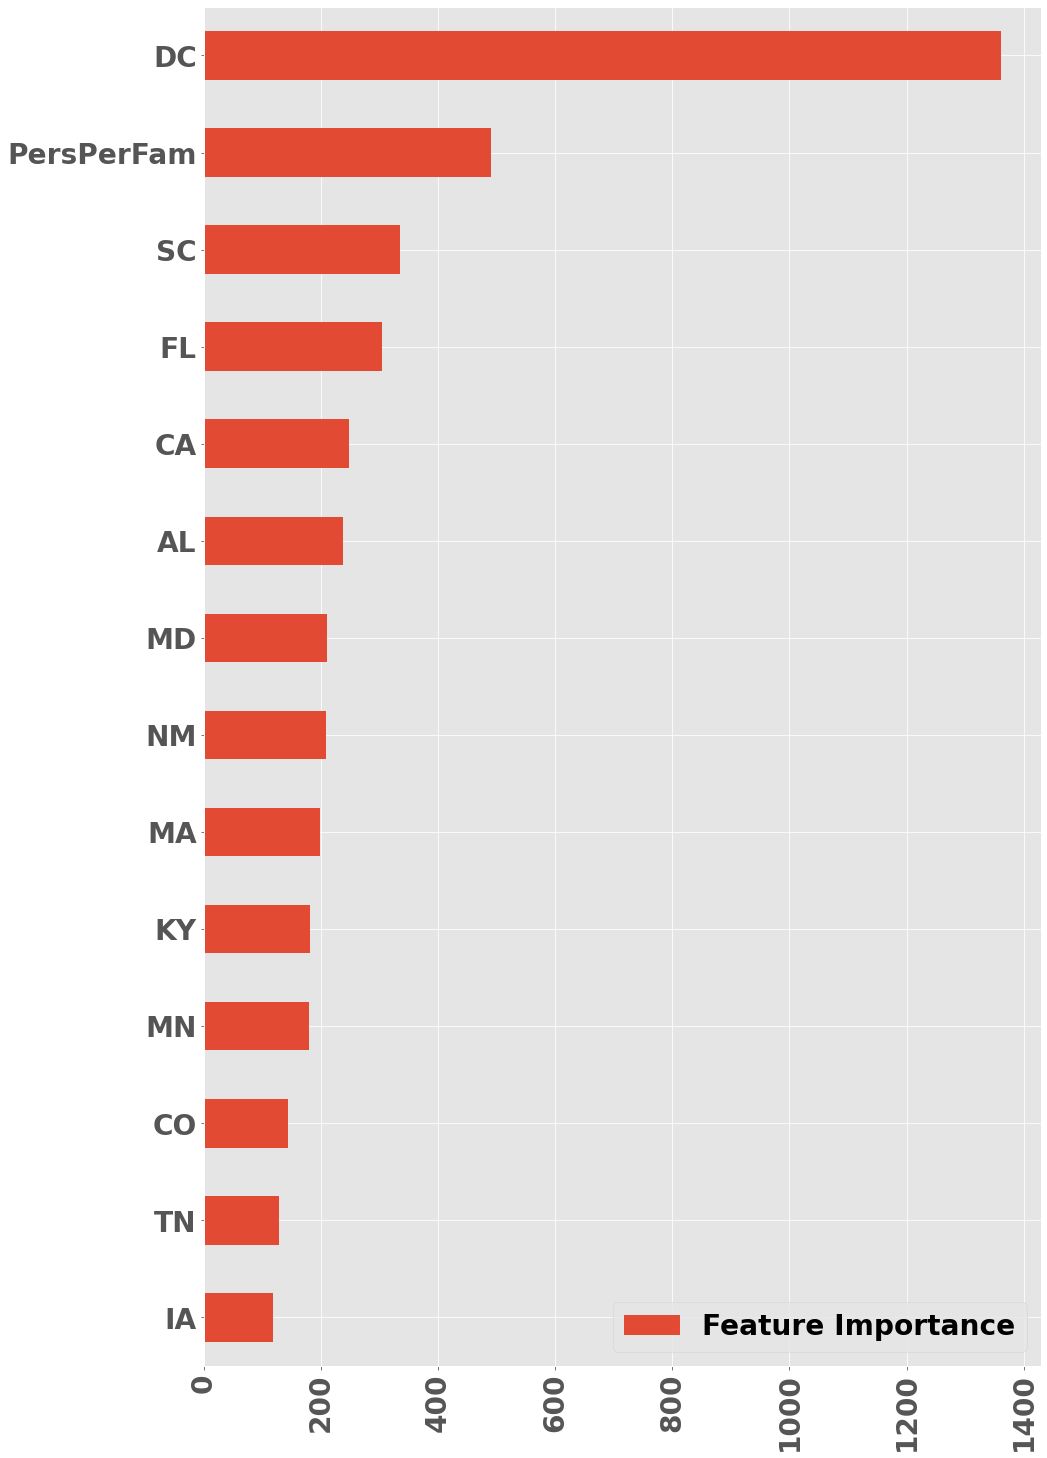

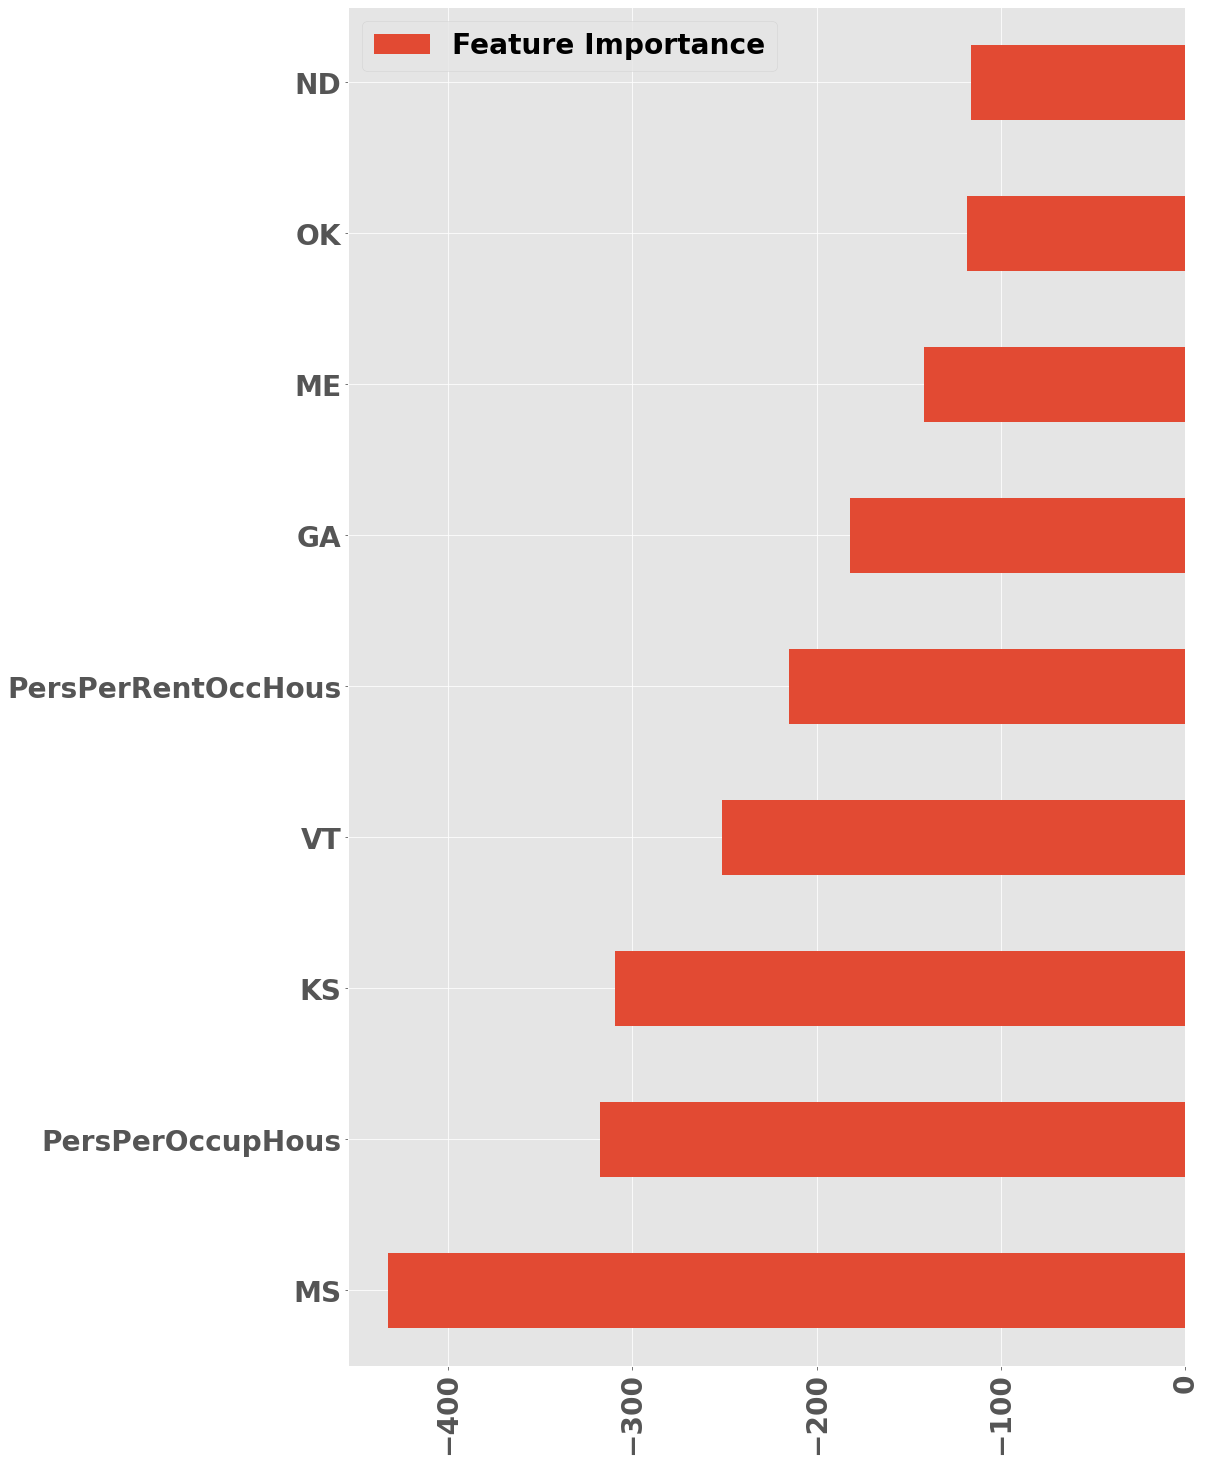

In [36]:
# FEATURE IMPORTANCE Data NOT normalized using Lasso model - NOT the best one ...

#### Replac the NaN of the normalized data with the median. Linear Regressors are
#to handle regression 
trainFinalFI = XnotNorm.fillna(XnotNorm.median()).clip(-1e11,1e11)
yFinalFI = ynotNorm.fillna(ynotNorm.median()).clip(-1e11,1e11)


lasso=Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
lasso.fit(trainFinalFI,yFinalFI)

FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=trainFinalFI.columns)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 28}

plt.rc('font', **font)

# Focus on those with 0 importance
#print(FI_lasso.sort_values("Feature Importance",ascending=False).to_string())
#print("_"*80)
FI_lasso[FI_lasso["Feature Importance"] >100].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
FI_lasso[FI_lasso["Feature Importance"] <-100].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

### for the next three cells, I will run different Linear Regressors to determine which one works best for my dataset

In [382]:
# CROSS VALIDATION

def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [383]:
# Lin reg ALL models HYPERPARAMS NOT optimized

## Fill in the NaN data with the median values
ynorm = ynorm.fillna(ynorm.median()).clip(-1e11,1e11)
XNorm = XNorm.fillna(XNorm.median()).clip(-1e11,1e11)

models = [RandomForestRegressor(),GradientBoostingRegressor(), ExtraTreesRegressor(), BaggingRegressor(), AdaBoostRegressor()]
names = ["RandomForestRegressor", "GradientBoostingRegressor", "ExtraTreesRegressor", "BaggingRegressor", 
         "AdaBoostRegressor"]

In [325]:
# Run the models and compare

ModScores = {}

for name, model in zip(names, models):
    score = rmse_cv(model, XNorm, ynorm)
    ModScores[name] = score.mean()
    print("{}: {:.2f}".format(name,score.mean()))

print("_"*100)
for key, value in sorted(ModScores.items(), key = itemgetter(1), reverse = False):
    print(key, round(value,3))

RandomForestRegressor: 0.57
GradientBoostingRegressor: 0.57
ExtraTreesRegressor: 0.57
BaggingRegressor: 0.59
AdaBoostRegressor: 0.81
____________________________________________________________________________________________________
GradientBoostingRegressor 0.566
ExtraTreesRegressor 0.569
RandomForestRegressor 0.571
BaggingRegressor 0.589
AdaBoostRegressor 0.805



### I will now select a model and find the best hyperparameters for the model via grid searching 


In [387]:
# Optimize hyper params for one model
model = GradientBoostingRegressor()

#param_grid = [{},]

param_grid = {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5,10], 'n_estimators': [50, 100]}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', refit= True)
gs = grid_search.fit(XNorm, ynorm)

print(gs.best_estimator_)
print(gs.best_index_)
print(sorted(gs.cv_results_.keys()))
print(" ")
print(gs.get_params().keys())
print(" ")
print(gs.get_params())

GradientBoostingRegressor(max_depth=5, min_samples_split=5, n_estimators=50)
8
['mean_fit_time', 'mean_score_time', 'mean_test_score', 'param_max_depth', 'param_min_samples_split', 'param_n_estimators', 'params', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_fit_time', 'std_score_time', 'std_test_score']
 
dict_keys(['cv', 'error_score', 'estimator__alpha', 'estimator__ccp_alpha', 'estimator__criterion', 'estimator__init', 'estimator__learning_rate', 'estimator__loss', 'estimator__max_depth', 'estimator__max_features', 'estimator__max_leaf_nodes', 'estimator__min_impurity_decrease', 'estimator__min_impurity_split', 'estimator__min_samples_leaf', 'estimator__min_samples_split', 'estimator__min_weight_fraction_leaf', 'estimator__n_estimators', 'estimator__n_iter_no_change', 'estimator__random_state', 'estimator__subsample', 'estimator__tol', 'estimator__validation_fraction', 'estimator__verbose', 'estimato

In [384]:
model = GradientBoostingRegressor(max_depth=5, min_samples_split=5, n_estimators=50)

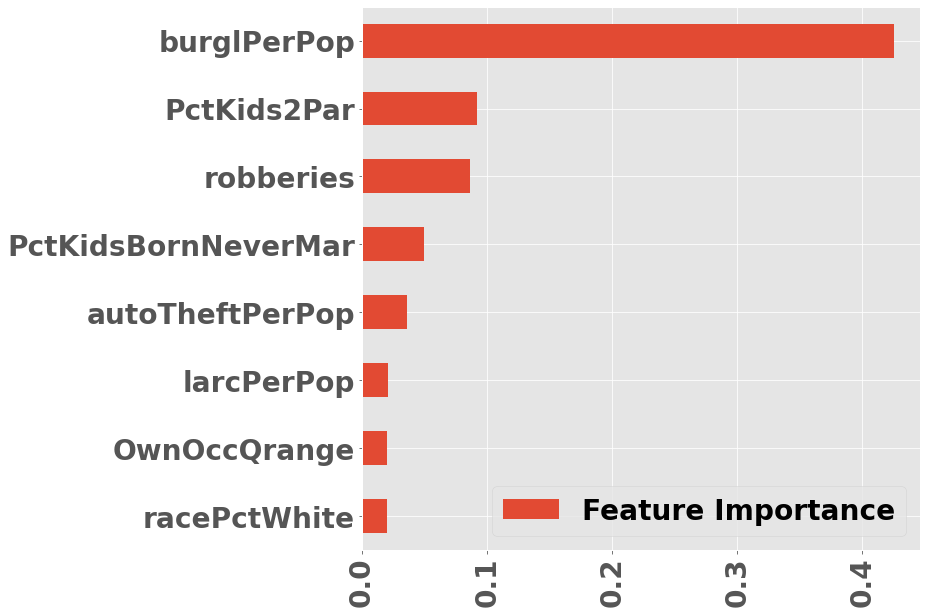

In [386]:
# FEATURE IMPORTANCE - NORMALIZED - GBR model
# NOTE GBR - has NO Negative feature importance

trainFinalFI = XNorm
yFinalFI = ynorm

GBR = GradientBoostingRegressor(max_depth=5, min_samples_split=5, n_estimators=50)

GBR.fit(trainFinalFI,yFinalFI)


font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 28}

plt.rc('font', **font)

FI_GBR = pd.DataFrame({"Feature Importance":GBR.feature_importances_,}, index=trainFinalFI.columns)
FI_GBR[FI_GBR["Feature Importance"] > 0.02].sort_values("Feature Importance").plot(kind="barh",figsize=(10,10))
plt.xticks(rotation=90)
plt.xticks(rotation=90)
plt.show()


# FI_GBR[FI_GBR["Feature Importance"] < 0.02].sort_values("Feature Importance").plot(kind="barh",figsize=(15,15))
# plt.xticks(rotation=90)
# plt.xticks(rotation=90)
# plt.show()

In [328]:
# List of important features for GBR
FI_GBR = pd.DataFrame({"Feature Importance":GBR.feature_importances_,}, index=trainFinalFI.columns)
FI_GBR=FI_GBR.sort_values('Feature Importance', ascending = False)
print(FI_GBR[FI_GBR["Feature Importance"] > 0.0025])

                     Feature Importance
burglPerPop                    0.424467
PctKids2Par                    0.092020
robberies                      0.086125
PctKidsBornNeverMar            0.049130
autoTheftPerPop                0.035629
OwnOccQrange                   0.021566
larcPerPop                     0.020974
racePctWhite                   0.020567
racepctblack                   0.018201
pctWInvInc                     0.010791
nonViolPerPop                  0.010070
countyCode                     0.008087
murders                        0.007818
PctHousLess3BR                 0.007669
PctPersDenseHous               0.007004
PctLess9thGrade                0.006016
racePctHisp                    0.006011
NumStreet                      0.005938
MalePctDivorce                 0.005413
AsianPerCap                    0.004883
PctUsePubTrans                 0.004753
TotalPctDiv                    0.004131
HispPerCap                     0.003955
PctVacantBoarded               0.003937


In [335]:
###  Plot the Learning Curves

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize = (10,10))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = 1-np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = 1-np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Frank\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


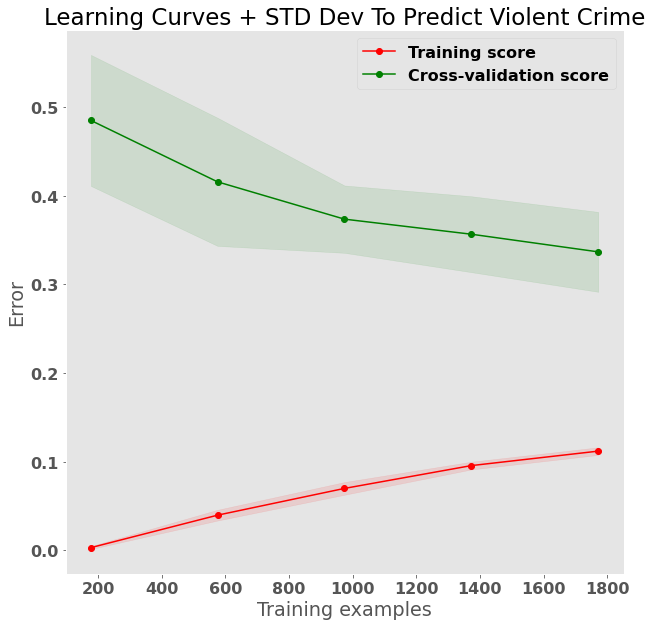

In [390]:
# LEARNING CURVES Train / Validation
# Note - ynotNorm !!
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)


title = "Learning Curves + STD Dev To Predict Violent Crime"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(model, title, XNorm, ynotNorm, cv=cv, n_jobs=5)

#plot_learning_curve(model, title, XNorm, y, ylim=(0.01, 0.99), cv=cv, n_jobs=4)

In [392]:
# Split into Train & Test

#   NOTE - For ed purposes ynotNorm was USED !!!

X_train, X_test, y_train, y_test = train_test_split(XNorm, ynotNorm, test_size=0.2, random_state=42)
print ('X_train: ', X_train.shape)
print ('X_test: ', X_test.shape)
print ('y_train: ', y_train.shape)
print ('y_test: ', y_test.shape)

X_train:  (1772, 138)
X_test:  (443, 138)
y_train:  (1772,)
y_test:  (443,)


In [393]:
# Model FINAL fit and evaluation on test

model.fit(X_train, y_train)

final_predictions = model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) 
print("rmse on test ", round(final_rmse, 4))

final_mae = mean_absolute_error(y_test, final_predictions)
print("mae on test ", round(final_mae, 4))

rmse on test  324.3939
mae on test  202.6531


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


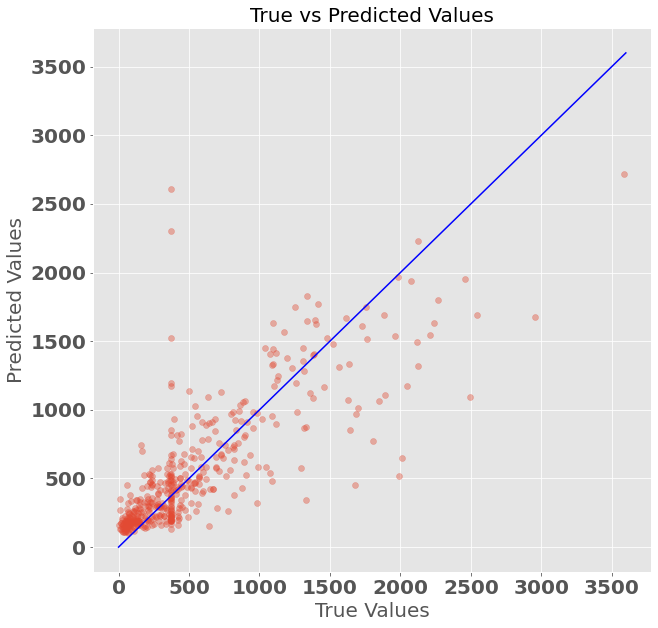

In [396]:
# PLOT True vs Predicted



params = {'axes.labelsize': 20,
          'axes.titlesize': 20}
plt.rcParams.update(params)


font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}

plt.rc('font', **font)

xChart = [np.array(y_test)]
yChart = [np.array(final_predictions)]

plt.figure(figsize = (10,10))
plt.scatter(xChart,yChart, alpha=0.4)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
# plt.xlim(0,60)
# plt.ylim(0,60)
plt.plot( [0,3600],[0,3600], 'b')

plt.show()

# plt.scatter(xChart,yChart, alpha=0.3)
# # plt.xlim(0,30)
# # plt.ylim(0,30)
# plt.plot([0,3600],[0,3600], 'b')
# plt.show()

# Creating a Neural Network 

In [397]:
# Transfer data to NN format

x_val = X_test
partial_x_train = X_train
y_val = y_test
partial_y_train = y_train

print("partial_x_train ", partial_x_train.shape)
print("partial_y_train ", partial_y_train.shape)

print("x_val ", x_val.shape)
print("y_val ", y_val.shape)

partial_x_train  (1772, 138)
partial_y_train  (1772,)
x_val  (443, 138)
y_val  (443,)


In [398]:
# NN MODEL
from keras import models
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.0001),
                       input_shape=(partial_x_train.shape[1],)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
model.add(layers.Dense(1))
model.summary()

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
print("model compiled")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 32)                4448      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_9 (Batch (None, 32)                128       
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 8)                

In [399]:
history = model.fit(partial_x_train, partial_y_train,
                    validation_data=(x_val, y_val), 
                    verbose=1,
                   epochs=500)

Epoch 1/500
56/56 [==============================] - 2s 6ms/step - loss: 608621.4567 - mae: 550.9741 - val_loss: 599650.0000 - val_mae: 546.3437
Epoch 2/500
56/56 [==============================] - 0s 1ms/step - loss: 678792.0587 - mae: 562.7114 - val_loss: 595237.5625 - val_mae: 544.2206
Epoch 3/500
56/56 [==============================] - 0s 1ms/step - loss: 686182.1897 - mae: 563.2023 - val_loss: 587577.6875 - val_mae: 540.7385
Epoch 4/500
56/56 [==============================] - 0s 1ms/step - loss: 627631.3860 - mae: 551.0753 - val_loss: 577440.7500 - val_mae: 536.1405
Epoch 5/500
56/56 [==============================] - 0s 1ms/step - loss: 646451.3125 - mae: 556.5022 - val_loss: 565497.8750 - val_mae: 530.7493
Epoch 6/500
56/56 [==============================] - 0s 1ms/step - loss: 568992.1705 - mae: 524.7620 - val_loss: 550795.3125 - val_mae: 523.8265
Epoch 7/500
56/56 [==============================] - 0s 1ms/step - loss: 724226.3498 - mae: 579.8695 - val_loss: 534540.6875 - val

56/56 [==============================] - 0s 1ms/step - loss: 102830.7559 - mae: 215.9534 - val_loss: 100719.0859 - val_mae: 199.5090
Epoch 114/500
56/56 [==============================] - 0s 1ms/step - loss: 126215.6450 - mae: 233.6212 - val_loss: 99957.7422 - val_mae: 198.2027
Epoch 115/500
56/56 [==============================] - 0s 1ms/step - loss: 118328.8498 - mae: 222.1717 - val_loss: 99498.6797 - val_mae: 199.3390
Epoch 116/500
56/56 [==============================] - 0s 1ms/step - loss: 144559.6068 - mae: 238.6648 - val_loss: 98025.7500 - val_mae: 195.4103
Epoch 117/500
56/56 [==============================] - 0s 1ms/step - loss: 137832.4393 - mae: 231.7925 - val_loss: 99949.2109 - val_mae: 199.5997
Epoch 118/500
56/56 [==============================] - 0s 1ms/step - loss: 128631.6059 - mae: 230.2523 - val_loss: 98000.1875 - val_mae: 196.7333
Epoch 119/500
56/56 [==============================] - 0s 1ms/step - loss: 124495.1859 - mae: 220.3275 - val_loss: 99720.9062 - val_mae: 

Epoch 169/500
56/56 [==============================] - 0s 1ms/step - loss: 109416.3166 - mae: 211.5318 - val_loss: 98701.5156 - val_mae: 196.5588
Epoch 170/500
56/56 [==============================] - 0s 1ms/step - loss: 103958.8457 - mae: 209.3879 - val_loss: 99718.5625 - val_mae: 198.1509
Epoch 171/500
56/56 [==============================] - 0s 1ms/step - loss: 116135.9178 - mae: 222.2661 - val_loss: 103689.0781 - val_mae: 198.9534
Epoch 172/500
56/56 [==============================] - 0s 1ms/step - loss: 119554.0530 - mae: 219.1001 - val_loss: 101649.9844 - val_mae: 196.7223
Epoch 173/500
56/56 [==============================] - 0s 1ms/step - loss: 97563.2728 - mae: 207.8284 - val_loss: 103753.3203 - val_mae: 200.2942
Epoch 174/500
56/56 [==============================] - 0s 1ms/step - loss: 118313.0784 - mae: 218.0505 - val_loss: 102945.1484 - val_mae: 200.3156
Epoch 175/500
56/56 [==============================] - 0s 1ms/step - loss: 128868.3369 - mae: 233.3347 - val_loss: 103676

Epoch 225/500
56/56 [==============================] - 0s 1ms/step - loss: 127711.5274 - mae: 228.1360 - val_loss: 103626.7812 - val_mae: 199.7862
Epoch 226/500
56/56 [==============================] - 0s 1ms/step - loss: 97934.5803 - mae: 206.8043 - val_loss: 105093.7969 - val_mae: 203.0216
Epoch 227/500
56/56 [==============================] - 0s 1ms/step - loss: 114659.8294 - mae: 218.0652 - val_loss: 101789.5781 - val_mae: 199.9345
Epoch 228/500
56/56 [==============================] - 0s 1ms/step - loss: 115609.6831 - mae: 224.9232 - val_loss: 103985.2656 - val_mae: 204.3242
Epoch 229/500
56/56 [==============================] - 0s 1ms/step - loss: 102109.7608 - mae: 212.2418 - val_loss: 104090.5703 - val_mae: 200.9108
Epoch 230/500
56/56 [==============================] - 0s 1ms/step - loss: 119546.7444 - mae: 217.0042 - val_loss: 97704.4219 - val_mae: 196.2108
Epoch 231/500
56/56 [==============================] - 0s 1ms/step - loss: 119256.9319 - mae: 224.0163 - val_loss: 99424

Epoch 281/500
56/56 [==============================] - 0s 1ms/step - loss: 120597.0064 - mae: 224.9636 - val_loss: 100052.2188 - val_mae: 197.8780
Epoch 282/500
56/56 [==============================] - 0s 1ms/step - loss: 117168.9970 - mae: 220.7926 - val_loss: 99513.2422 - val_mae: 196.1730
Epoch 283/500
56/56 [==============================] - 0s 1ms/step - loss: 112900.5691 - mae: 222.6257 - val_loss: 97748.6250 - val_mae: 196.3540
Epoch 284/500
56/56 [==============================] - 0s 1ms/step - loss: 130572.2943 - mae: 223.8409 - val_loss: 99298.9688 - val_mae: 198.3417
Epoch 285/500
56/56 [==============================] - 0s 1ms/step - loss: 98127.1675 - mae: 207.7709 - val_loss: 100534.9766 - val_mae: 199.6183
Epoch 286/500
56/56 [==============================] - 0s 1ms/step - loss: 106710.5106 - mae: 208.8569 - val_loss: 101188.3047 - val_mae: 197.2794
Epoch 287/500
56/56 [==============================] - 0s 1ms/step - loss: 119152.5880 - mae: 224.7202 - val_loss: 105511.

Epoch 337/500
56/56 [==============================] - 0s 1ms/step - loss: 106518.2649 - mae: 208.3216 - val_loss: 98221.4688 - val_mae: 199.8221
Epoch 338/500
56/56 [==============================] - 0s 1ms/step - loss: 104469.5525 - mae: 216.1641 - val_loss: 95129.4141 - val_mae: 198.6828
Epoch 339/500
56/56 [==============================] - 0s 1ms/step - loss: 101176.4442 - mae: 208.3000 - val_loss: 100917.7578 - val_mae: 198.6489
Epoch 340/500
56/56 [==============================] - 0s 1ms/step - loss: 99371.8466 - mae: 205.8755 - val_loss: 102116.5156 - val_mae: 198.8541
Epoch 341/500
56/56 [==============================] - 0s 1ms/step - loss: 100433.0073 - mae: 205.1507 - val_loss: 104373.7812 - val_mae: 202.4052
Epoch 342/500
56/56 [==============================] - 0s 1ms/step - loss: 105240.0398 - mae: 208.7163 - val_loss: 100683.3828 - val_mae: 200.2160
Epoch 343/500
56/56 [==============================] - 0s 1ms/step - loss: 107393.1380 - mae: 207.7538 - val_loss: 105446

Epoch 393/500
56/56 [==============================] - 0s 1ms/step - loss: 92918.4962 - mae: 199.9516 - val_loss: 104088.3125 - val_mae: 203.2622
Epoch 394/500
56/56 [==============================] - 0s 1ms/step - loss: 99411.0395 - mae: 201.0215 - val_loss: 108351.0547 - val_mae: 205.0072
Epoch 395/500
56/56 [==============================] - 0s 1ms/step - loss: 92274.4131 - mae: 197.5436 - val_loss: 102754.5938 - val_mae: 202.5588
Epoch 396/500
56/56 [==============================] - 0s 1ms/step - loss: 111868.2719 - mae: 214.1488 - val_loss: 98943.1484 - val_mae: 201.4408
Epoch 397/500
56/56 [==============================] - 0s 1ms/step - loss: 115647.4472 - mae: 213.6454 - val_loss: 99737.0781 - val_mae: 199.9006
Epoch 398/500
56/56 [==============================] - 0s 1ms/step - loss: 114711.6465 - mae: 218.7274 - val_loss: 101256.9609 - val_mae: 199.9724
Epoch 399/500
56/56 [==============================] - 0s 1ms/step - loss: 101736.2378 - mae: 211.5224 - val_loss: 102249.3

Epoch 449/500
56/56 [==============================] - 0s 1ms/step - loss: 114726.8085 - mae: 219.2912 - val_loss: 108146.0781 - val_mae: 206.6206
Epoch 450/500
56/56 [==============================] - 0s 1ms/step - loss: 84334.2057 - mae: 196.5873 - val_loss: 104838.5703 - val_mae: 203.1854
Epoch 451/500
56/56 [==============================] - 0s 1ms/step - loss: 93710.5839 - mae: 202.9506 - val_loss: 103608.2891 - val_mae: 201.7206
Epoch 452/500
56/56 [==============================] - 0s 1ms/step - loss: 102456.5680 - mae: 203.6822 - val_loss: 104075.8125 - val_mae: 201.6139
Epoch 453/500
56/56 [==============================] - 0s 1ms/step - loss: 100351.9697 - mae: 206.0286 - val_loss: 102298.2969 - val_mae: 202.9467
Epoch 454/500
56/56 [==============================] - 0s 1ms/step - loss: 92476.9704 - mae: 200.6462 - val_loss: 104238.5625 - val_mae: 203.1722
Epoch 455/500
56/56 [==============================] - 0s 1ms/step - loss: 143267.2055 - mae: 227.1371 - val_loss: 101372

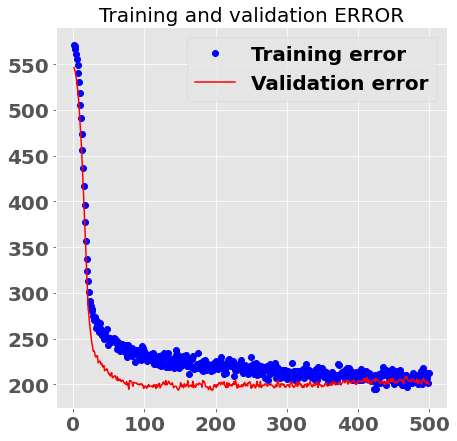

<Figure size 432x288 with 0 Axes>

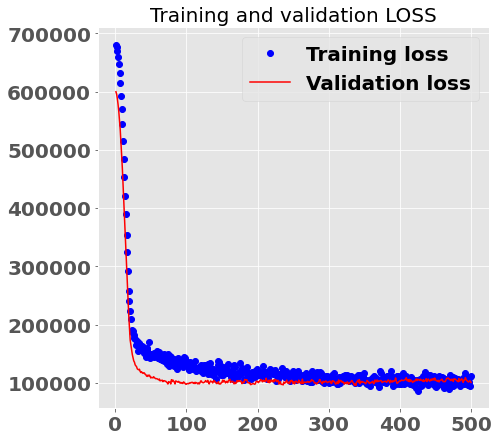

In [408]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 8}

acc = history.history['mae']
val_acc = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(7,7))
plt.plot(epochs, acc, 'bo', label='Training error')
plt.plot(epochs, val_acc, 'r', label='Validation error')
plt.title('Training and validation ERROR')
plt.legend()
plt.figure()

plt.figure(figsize=(7,7))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation LOSS')
plt.legend()
plt.show()

In [409]:
# PREDICT
final_predictions = model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) 
print("rmse on test ", round(final_rmse, 4))

final_mae = mean_absolute_error(y_test, final_predictions)
print("mae on test ", round(final_mae, 4))

rmse on test  317.0051
mae on test  199.8202


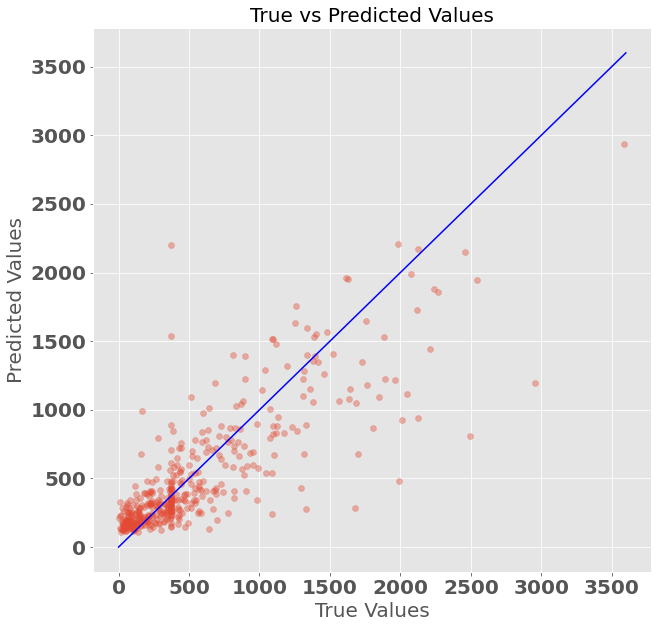

In [410]:
# PLOT True vs Predicted
params = {'axes.labelsize': 20,
          'axes.titlesize': 20}
plt.rcParams.update(params)


font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}

plt.rc('font', **font)
xChart = [np.array(y_test)]
yChart = [np.array(final_predictions)]

plt.figure(figsize = (10,10))
plt.scatter(xChart,yChart, alpha=0.4)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
# plt.xlim(0,60)
# plt.ylim(0,60)
plt.plot( [0,3600],[0,3600], 'b')

plt.show()

In [9]:
# # FEATURE IMPORTANCE - NORMALIZED - GBR model
# # NOTE GBR - has NO Negative feature importance

# trainFinalFI = XNorm
# yFinalFI = ynorm

# GBR =history


# FI_GBR = pd.DataFrame({"Feature Importance":GBR.feature_importances_,}, index=trainFinalFI.columns)
# FI_GBR[FI_GBR["Feature Importance"] > 0.02].sort_values("Feature Importance").plot(kind="barh",figsize=(6,6))
# plt.xticks(rotation=90)
# plt.xticks(rotation=90)
# plt.show()


# # FI_GBR[FI_GBR["Feature Importance"] < 0.02].sort_values("Feature Importance").plot(kind="barh",figsize=(15,15))
# # plt.xticks(rotation=90)
# # plt.xticks(rotation=90)
# # plt.show()

## Visualizing CrimeData

In [9]:
crimedata = pd.read_csv("crimedata.csv",sep='\s*,\s*',encoding='latin-1',engine='python',na_values=["?"]) # Read the csv file into dataframe
crimedata = crimedata.rename(columns={'Êcommunityname':'communityName'})
print (crimedata.info())

# fill missing values for the select columns under study with median value of the select columns
cols = ['HousVacant','PctHousOccup','PctHousOwnOcc','PctVacantBoarded','PctVacMore6Mos','PctUnemployed','PctEmploy','murdPerPop','rapesPerPop','robbbPerPop','assaultPerPop','ViolentCrimesPerPop','burglPerPop','larcPerPop','autoTheftPerPop','arsonsPerPop','nonViolPerPop', 'robberies']
crimedata.fillna(crimedata[cols].median(),inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Columns: 147 entries, communityName to nonViolPerPop
dtypes: float64(116), int64(29), object(2)
memory usage: 2.5+ MB
None


In [10]:

def plot_geography(variable):
    
    # Let's find out the outliers in `ViolentCrimesPerPop` response variable and plot those to find cities with highest crime rate in the US
    quartile_1, quartile_3 = np.percentile(crimedata[variable], [25, 75])
    print(quartile_1, quartile_3)
    iqr = quartile_3 - quartile_1
    print(iqr)
    lower_bound = quartile_1 #- (iqr * 1.5)
    print(lower_bound)
    upper_bound = quartile_3 #+ (iqr * 1.5)
    print(upper_bound)
    outliers_viol = crimedata.loc[crimedata[variable]>upper_bound,['communityName','state',variable]]


    ## Remove community Name(s) ending with "city". This helps dataframe(s) merging easier to get lat and lon
    outliers_viol['communityName'] = outliers_viol['communityName'].map(lambda result : re.sub(r'city','',result))
    outliers_nviol['communityName'] = outliers_nviol['communityName'].map(lambda result : re.sub(r'city','',result))

    ## read citie.json file to get latitude and longitude details of the cities
    file = "cities.json"
    with open(file, encoding="utf8") as city_file:
       dict_city = json.load(city_file)
    cities_lat_lon = json_normalize(dict_city)
    print(cities_lat_lon)
    #print (cities_lat_lon.info())

    ## merge cities dataframe(with cities_lat_lon dataframe to get lat and lon of the cities) with outliers_viol dataframe 
    ##and outliers_nviol to plot cities with highest violent/non-vilolent crime rate

    violent_crime_cities = pd.merge(outliers_viol,cities_lat_lon,left_on=["communityName","state"],right_on=["city","state"])
    violent_crime_cities = violent_crime_cities.drop(["city"],axis=1)
    #print (violent_crime_cities)
    

    

    a = 'Cities with highest '
    title_string = a + variable
    
    ## Cities with highest violent crime rate
    #levels = [(0,1),(2,3),(4,5),(6,7),(8,90)]
    levels = [(0,30),(31,60),(61,90),(91,120),(121,170), (171,999)]
    colors = ['rgb(175,175,50)','rgb(131,120,180)','rgb(78,230,138)','rgb(251,24,153)','rgb(227,126,28)', 'rgb(227,126,28)']
    cities = []
    for i in range(len(levels)):
        lim = levels[i]
        violent_crime_cities_sub = violent_crime_cities[lim[0]:lim[1]]
        
        ###Find the appropriate marker Size
        if np.mean(violent_crime_cities_sub[variable]) < 25:
            Marker_Size = violent_crime_cities_sub[variable] * 20/np.mean(violent_crime_cities_sub[variable])
        else: 
            Marker_Size = 12 + violent_crime_cities_sub[variable]/np.mean(violent_crime_cities_sub[variable])*(.1)
            
        
        city_outline = dict(
            type = "scattergeo",
            locationmode = 'USA-states',
            lon = violent_crime_cities_sub['longitude'],
            lat = violent_crime_cities_sub['latitude'],
            text = violent_crime_cities_sub['communityName'] +' '+ violent_crime_cities_sub[variable].astype(str),
            mode = "markers",
            marker = dict(
            size = Marker_Size,
            color = colors[i]
            ),  
        name = '{0} - {1}'.format(lim[0],lim[1])
        )
        layout2 = dict(
            title = title_string,
            geo = dict(
                scope='usa',
                projection=dict( type='albers usa' ),
                showlakes = True,
                lakecolor = 'rgb(85,173,240)'),
        ) 
        cities.append(city_outline)

    fig2= dict( data=cities, layout=layout2)
    iplot( fig2, validate=False)

## Lasso Fit top 4

In [11]:
plot_geography('PersPerFam')

2.99 3.22
0.22999999999999998
2.99
3.22
               city   latitude   longitude state
0           NewYork  40.712784  -74.005941    NY
1        Greenville  35.612700  -77.366400    NC
2              Waco  31.549300  -97.146700    TX
3          Richmond  37.935800 -122.347700    CA
4        LosAngeles  34.052234 -118.243685    CA
..              ...        ...         ...   ...
237       Hamtramck  42.392800  -83.049600    MI
238          Eureka  40.802100 -124.163700    CA
239    BentonHarbor  42.116700  -86.454200    MI
240       Montclair  34.077510 -117.689778    CA
241  Greenfieldtown  42.587900  -72.599400    MA

[242 rows x 4 columns]


<ipython-input-10-afd6e5d81e6b>:23: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [12]:
plot_geography('PersPerOccupHous')

2.41 2.77
0.3599999999999999
2.41
2.77
               city   latitude   longitude state
0           NewYork  40.712784  -74.005941    NY
1        Greenville  35.612700  -77.366400    NC
2              Waco  31.549300  -97.146700    TX
3          Richmond  37.935800 -122.347700    CA
4        LosAngeles  34.052234 -118.243685    CA
..              ...        ...         ...   ...
237       Hamtramck  42.392800  -83.049600    MI
238          Eureka  40.802100 -124.163700    CA
239    BentonHarbor  42.116700  -86.454200    MI
240       Montclair  34.077510 -117.689778    CA
241  Greenfieldtown  42.587900  -72.599400    MA

[242 rows x 4 columns]


<ipython-input-10-afd6e5d81e6b>:23: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [13]:
plot_geography('householdsize')

2.5 2.85
0.3500000000000001
2.5
2.85
               city   latitude   longitude state
0           NewYork  40.712784  -74.005941    NY
1        Greenville  35.612700  -77.366400    NC
2              Waco  31.549300  -97.146700    TX
3          Richmond  37.935800 -122.347700    CA
4        LosAngeles  34.052234 -118.243685    CA
..              ...        ...         ...   ...
237       Hamtramck  42.392800  -83.049600    MI
238          Eureka  40.802100 -124.163700    CA
239    BentonHarbor  42.116700  -86.454200    MI
240       Montclair  34.077510 -117.689778    CA
241  Greenfieldtown  42.587900  -72.599400    MA

[242 rows x 4 columns]


<ipython-input-10-afd6e5d81e6b>:23: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [14]:
plot_geography('MedNumBR')

2.0 3.0
1.0
2.0
3.0
               city   latitude   longitude state
0           NewYork  40.712784  -74.005941    NY
1        Greenville  35.612700  -77.366400    NC
2              Waco  31.549300  -97.146700    TX
3          Richmond  37.935800 -122.347700    CA
4        LosAngeles  34.052234 -118.243685    CA
..              ...        ...         ...   ...
237       Hamtramck  42.392800  -83.049600    MI
238          Eureka  40.802100 -124.163700    CA
239    BentonHarbor  42.116700  -86.454200    MI
240       Montclair  34.077510 -117.689778    CA
241  Greenfieldtown  42.587900  -72.599400    MA

[242 rows x 4 columns]


<ipython-input-10-afd6e5d81e6b>:23: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



## Lasso Fit bottom 4

In [15]:
plot_geography('TotalPctDiv')

8.575 12.985
4.41
8.575
12.985
               city   latitude   longitude state
0           NewYork  40.712784  -74.005941    NY
1        Greenville  35.612700  -77.366400    NC
2              Waco  31.549300  -97.146700    TX
3          Richmond  37.935800 -122.347700    CA
4        LosAngeles  34.052234 -118.243685    CA
..              ...        ...         ...   ...
237       Hamtramck  42.392800  -83.049600    MI
238          Eureka  40.802100 -124.163700    CA
239    BentonHarbor  42.116700  -86.454200    MI
240       Montclair  34.077510 -117.689778    CA
241  Greenfieldtown  42.587900  -72.599400    MA

[242 rows x 4 columns]


<ipython-input-10-afd6e5d81e6b>:23: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [16]:
plot_geography('PctRecImmig5')

0.28 2.0149999999999997
1.7349999999999997
0.28
2.0149999999999997
               city   latitude   longitude state
0           NewYork  40.712784  -74.005941    NY
1        Greenville  35.612700  -77.366400    NC
2              Waco  31.549300  -97.146700    TX
3          Richmond  37.935800 -122.347700    CA
4        LosAngeles  34.052234 -118.243685    CA
..              ...        ...         ...   ...
237       Hamtramck  42.392800  -83.049600    MI
238          Eureka  40.802100 -124.163700    CA
239    BentonHarbor  42.116700  -86.454200    MI
240       Montclair  34.077510 -117.689778    CA
241  Greenfieldtown  42.587900  -72.599400    MA

[242 rows x 4 columns]


<ipython-input-10-afd6e5d81e6b>:23: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [17]:
plot_geography('PersPerOwnOccHous')

2.55 2.9
0.3500000000000001
2.55
2.9
               city   latitude   longitude state
0           NewYork  40.712784  -74.005941    NY
1        Greenville  35.612700  -77.366400    NC
2              Waco  31.549300  -97.146700    TX
3          Richmond  37.935800 -122.347700    CA
4        LosAngeles  34.052234 -118.243685    CA
..              ...        ...         ...   ...
237       Hamtramck  42.392800  -83.049600    MI
238          Eureka  40.802100 -124.163700    CA
239    BentonHarbor  42.116700  -86.454200    MI
240       Montclair  34.077510 -117.689778    CA
241  Greenfieldtown  42.587900  -72.599400    MA

[242 rows x 4 columns]


<ipython-input-10-afd6e5d81e6b>:23: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [18]:
plot_geography('PersPerRentOccHous')

2.11 2.53
0.41999999999999993
2.11
2.53
               city   latitude   longitude state
0           NewYork  40.712784  -74.005941    NY
1        Greenville  35.612700  -77.366400    NC
2              Waco  31.549300  -97.146700    TX
3          Richmond  37.935800 -122.347700    CA
4        LosAngeles  34.052234 -118.243685    CA
..              ...        ...         ...   ...
237       Hamtramck  42.392800  -83.049600    MI
238          Eureka  40.802100 -124.163700    CA
239    BentonHarbor  42.116700  -86.454200    MI
240       Montclair  34.077510 -117.689778    CA
241  Greenfieldtown  42.587900  -72.599400    MA

[242 rows x 4 columns]


<ipython-input-10-afd6e5d81e6b>:23: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



## Machine Learning Top 8 important features organized in descendin order. 

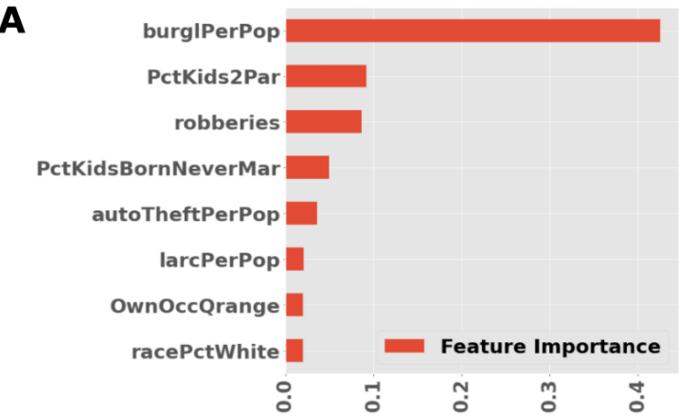

In [19]:
plot_geography('burglPerPop')

512.1850000000001 1348.67
836.485
512.1850000000001
1348.67
               city   latitude   longitude state
0           NewYork  40.712784  -74.005941    NY
1        Greenville  35.612700  -77.366400    NC
2              Waco  31.549300  -97.146700    TX
3          Richmond  37.935800 -122.347700    CA
4        LosAngeles  34.052234 -118.243685    CA
..              ...        ...         ...   ...
237       Hamtramck  42.392800  -83.049600    MI
238          Eureka  40.802100 -124.163700    CA
239    BentonHarbor  42.116700  -86.454200    MI
240       Montclair  34.077510 -117.689778    CA
241  Greenfieldtown  42.587900  -72.599400    MA

[242 rows x 4 columns]


<ipython-input-10-afd6e5d81e6b>:23: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [20]:
plot_geography('PctKids2Par')

63.989999999999995 80.39500000000001
16.405000000000015
63.989999999999995
80.39500000000001
               city   latitude   longitude state
0           NewYork  40.712784  -74.005941    NY
1        Greenville  35.612700  -77.366400    NC
2              Waco  31.549300  -97.146700    TX
3          Richmond  37.935800 -122.347700    CA
4        LosAngeles  34.052234 -118.243685    CA
..              ...        ...         ...   ...
237       Hamtramck  42.392800  -83.049600    MI
238          Eureka  40.802100 -124.163700    CA
239    BentonHarbor  42.116700  -86.454200    MI
240       Montclair  34.077510 -117.689778    CA
241  Greenfieldtown  42.587900  -72.599400    MA

[242 rows x 4 columns]


<ipython-input-10-afd6e5d81e6b>:23: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [21]:
plot_geography('robberies')

5.0 70.0
65.0
5.0
70.0
               city   latitude   longitude state
0           NewYork  40.712784  -74.005941    NY
1        Greenville  35.612700  -77.366400    NC
2              Waco  31.549300  -97.146700    TX
3          Richmond  37.935800 -122.347700    CA
4        LosAngeles  34.052234 -118.243685    CA
..              ...        ...         ...   ...
237       Hamtramck  42.392800  -83.049600    MI
238          Eureka  40.802100 -124.163700    CA
239    BentonHarbor  42.116700  -86.454200    MI
240       Montclair  34.077510 -117.689778    CA
241  Greenfieldtown  42.587900  -72.599400    MA

[242 rows x 4 columns]


<ipython-input-10-afd6e5d81e6b>:23: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [22]:
plot_geography('PctKidsBornNeverMar')

1.07 3.91
2.84
1.07
3.91
               city   latitude   longitude state
0           NewYork  40.712784  -74.005941    NY
1        Greenville  35.612700  -77.366400    NC
2              Waco  31.549300  -97.146700    TX
3          Richmond  37.935800 -122.347700    CA
4        LosAngeles  34.052234 -118.243685    CA
..              ...        ...         ...   ...
237       Hamtramck  42.392800  -83.049600    MI
238          Eureka  40.802100 -124.163700    CA
239    BentonHarbor  42.116700  -86.454200    MI
240       Montclair  34.077510 -117.689778    CA
241  Greenfieldtown  42.587900  -72.599400    MA

[242 rows x 4 columns]


<ipython-input-10-afd6e5d81e6b>:23: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [23]:
plot_geography('autoTheftPerPop')

157.06 589.2249999999999
432.1649999999999
157.06
589.2249999999999
               city   latitude   longitude state
0           NewYork  40.712784  -74.005941    NY
1        Greenville  35.612700  -77.366400    NC
2              Waco  31.549300  -97.146700    TX
3          Richmond  37.935800 -122.347700    CA
4        LosAngeles  34.052234 -118.243685    CA
..              ...        ...         ...   ...
237       Hamtramck  42.392800  -83.049600    MI
238          Eureka  40.802100 -124.163700    CA
239    BentonHarbor  42.116700  -86.454200    MI
240       Montclair  34.077510 -117.689778    CA
241  Greenfieldtown  42.587900  -72.599400    MA

[242 rows x 4 columns]


<ipython-input-10-afd6e5d81e6b>:23: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [24]:
plot_geography('larcPerPop')

2040.74 4334.674999999999
2293.9349999999995
2040.74
4334.674999999999
               city   latitude   longitude state
0           NewYork  40.712784  -74.005941    NY
1        Greenville  35.612700  -77.366400    NC
2              Waco  31.549300  -97.146700    TX
3          Richmond  37.935800 -122.347700    CA
4        LosAngeles  34.052234 -118.243685    CA
..              ...        ...         ...   ...
237       Hamtramck  42.392800  -83.049600    MI
238          Eureka  40.802100 -124.163700    CA
239    BentonHarbor  42.116700  -86.454200    MI
240       Montclair  34.077510 -117.689778    CA
241  Greenfieldtown  42.587900  -72.599400    MA

[242 rows x 4 columns]


<ipython-input-10-afd6e5d81e6b>:23: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [25]:
plot_geography('OwnOccQrange')

32200.0 65450.0
33250.0
32200.0
65450.0
               city   latitude   longitude state
0           NewYork  40.712784  -74.005941    NY
1        Greenville  35.612700  -77.366400    NC
2              Waco  31.549300  -97.146700    TX
3          Richmond  37.935800 -122.347700    CA
4        LosAngeles  34.052234 -118.243685    CA
..              ...        ...         ...   ...
237       Hamtramck  42.392800  -83.049600    MI
238          Eureka  40.802100 -124.163700    CA
239    BentonHarbor  42.116700  -86.454200    MI
240       Montclair  34.077510 -117.689778    CA
241  Greenfieldtown  42.587900  -72.599400    MA

[242 rows x 4 columns]


<ipython-input-10-afd6e5d81e6b>:23: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [26]:
plot_geography('racePctWhite')

76.32 96.225
19.905
76.32
96.225
               city   latitude   longitude state
0           NewYork  40.712784  -74.005941    NY
1        Greenville  35.612700  -77.366400    NC
2              Waco  31.549300  -97.146700    TX
3          Richmond  37.935800 -122.347700    CA
4        LosAngeles  34.052234 -118.243685    CA
..              ...        ...         ...   ...
237       Hamtramck  42.392800  -83.049600    MI
238          Eureka  40.802100 -124.163700    CA
239    BentonHarbor  42.116700  -86.454200    MI
240       Montclair  34.077510 -117.689778    CA
241  Greenfieldtown  42.587900  -72.599400    MA

[242 rows x 4 columns]


<ipython-input-10-afd6e5d81e6b>:23: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Columns: 147 entries, communityName to nonViolPerPop
dtypes: float64(116), int64(29), object(2)
memory usage: 2.5+ MB
None


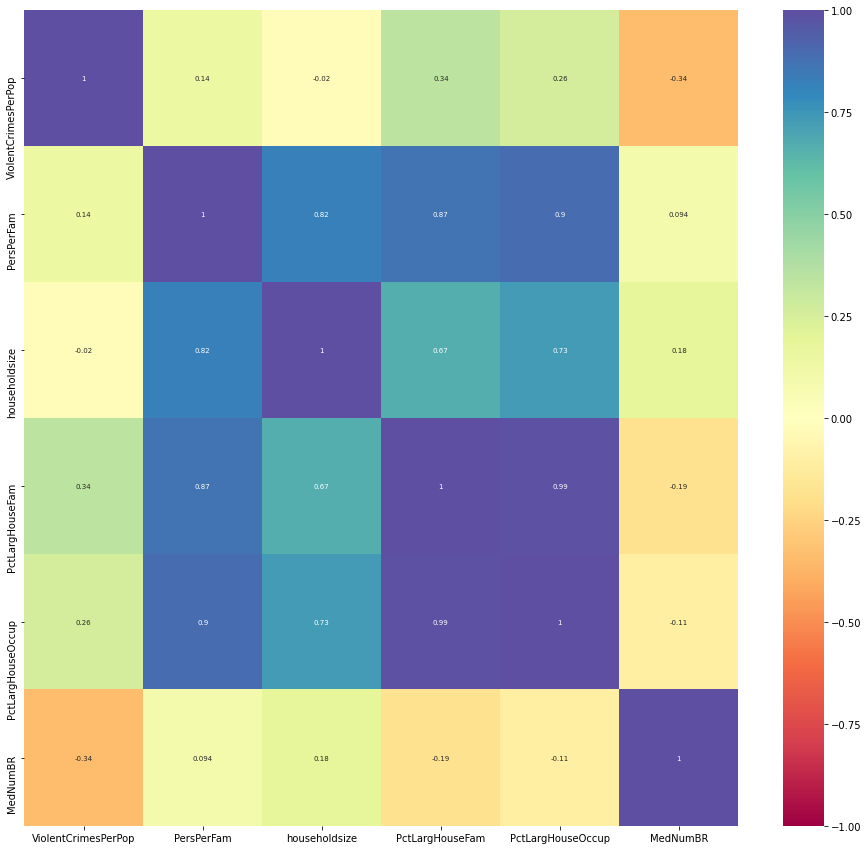

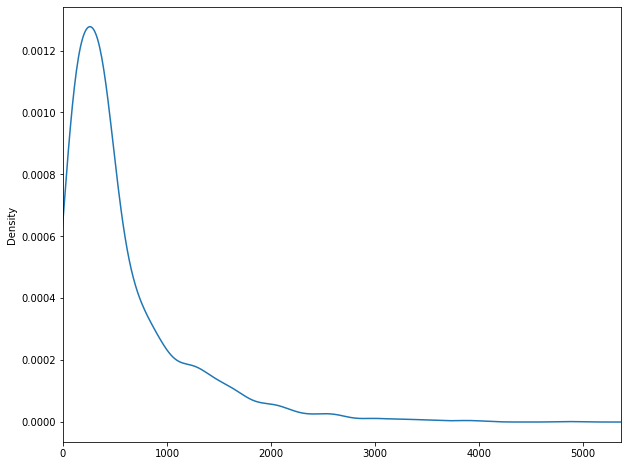

In [28]:

crimedata = pd.read_csv("crimedata.csv",sep='\s*,\s*',encoding='latin-1',engine='python',na_values=["?"]) # Read the csv file into dataframe
crimedata = crimedata.rename(columns={'Êcommunityname':'communityName'})
print (crimedata.info())

# fill missing values for the select columns under study with median value of the select columns
cols = ['ViolentCrimesPerPop','PersPerFam','householdsize', 'PctLargHouseFam', 'PctLargHouseOccup','MedNumBR'  ]
crimedata.fillna(crimedata[cols].median(),inplace=True)


crimedata_study = crimedata.filter(cols, axis=1)

### Find out the correlation between explanatory and response under study variables. Indepentdent variables under study is limited
### to Income and employment considering the huge number of variables in the dataset
crimedata_reg = crimedata_study
crimedata_reg_corr = crimedata_reg.corr()

### correlation matrix plot
plt.figure(figsize=(16,15))
sns.heatmap(crimedata_reg_corr,annot=True,annot_kws={"size": 7},vmin=-1.0, vmax=1.0,cmap="Spectral")

## "ViolentCrimesPerPop" Density plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax= crimedata_reg['ViolentCrimesPerPop'].plot(kind="kde")
plt.xlim(crimedata_reg['ViolentCrimesPerPop'].min(), crimedata_reg['ViolentCrimesPerPop'].max()*1.1)
plt.show()

### Thank you for reading through my Jupyter Notebook. I hope you hvae a good day.